#Simpsons transfer learning

### Устанавливаем все нужные библиотеки

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import pickle
from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

plt.ion()

##### Подключаем GPU

In [3]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


##### Подключаем гугл диск

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


#### Распаковываем данные из гугл диска в коллаб

In [0]:
!unzip -q "gdrive/My Drive/_DL_school/simpson/journey-springfield.zip" -d journey-springfield

#### Можно посмотреть параметры

In [6]:
!nvidia-smi
# import torch
torch.cuda.is_available()

Sun May 24 19:46:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

True

In [0]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы
RESCALE_SIZE = 299
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [0]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files) 
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            # Кодируем наши классы числами, и сохраняем в файл
            # print(dict(zip(self.label_encoder.classes_, self.label_encoder.transform(self.label_encoder.classes_))))
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
    # переопределяем метод len как количество фалов                  
    def __len__(self):
        return self.len_
    # подгружаем и возвращает картинку  
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        # подгружаем картинку
        x = self.load_sample(self.files[index])
        # ресайзим и возвращаем
        x = self._prepare_sample(x)
        # нормализуем
        x = np.array(x / 255, dtype='float32')
        # трансформируем по функии выше
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
    # ресайз    
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [0]:
# Показ картинок
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    # Функция transpose() транспонирует (меняет оси в обратном порядке) или перемещает оси массива в указанные положения.
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    # Функция clip() ограниченичивает элементы массива указанным интервалом допустимых значений.
    # Например, если указать интервал [5, 10], то все значения в массиве, которые меньше 5 примут значение равное 5, а все значения больше 10, будут равны 10.
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

* Загрузим данные:

In [0]:
TRAIN_DIR = Path('journey-springfield/train')
TEST_DIR = Path('journey-springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [0]:
from sklearn.model_selection import train_test_split

# Имя папки файла является лейблом
train_val_labels = [path.parent.name for path in train_val_files]
# Разбиваем размеченную часть на тестовую и валидационную выборки
# Этот параметр стратификации разделяется таким образом, что доля значений в образце будет такой же, как доля значений, предоставленных параметру стратификации.
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels, random_state=0)

In [0]:
val_dataset = SimpsonsDataset(val_files, mode='val')

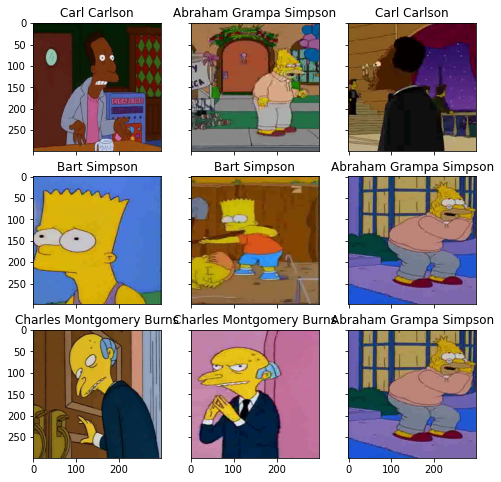

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
# flatten Вернуть копию массива, свернутого в одно измерение.
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    # получаем рандомную картинку с лейблом
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                             val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Подключаем модель inception_v3

In [14]:
from torchvision.models.inception import inception_v3
inception_mode = inception_v3(pretrained=True, aux_logits=False)


Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth


In [0]:
# Можно посмотреть слои Inception
# for name, child in inception_model0.named_children():
#     for name2, params in child.named_parameters():
#         print(name, name2)

In [0]:
# метод fit
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        # батчи, 3цвета, размер картинки torch.Size([128, 3, 299, 299])
        labels = labels.to(DEVICE)
        # правильные ответы tensor([32, 28,  7, .... ])
        optimizer.zero_grad()
        outputs = model(inputs)
        # 128 картинок с вероятностью для каждого класса torch.Size([128, 42])
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        preds = torch.argmax(outputs, 1)
        # тензор 128 числе соответствующие максимальному в каждой вероятности
        # inputs.size(0) размер батча 128
        # Кроссэнтропия лосс умножим на величину батча т.к. батчи могут быть не одинаковые и последний может быть меньше
        # в конце разделим на кол-во всего и получим средний лосс
        # print('loss.item()',loss.item(),'inputs.size(0)',inputs.size(0))
        running_loss += loss.item() * inputs.size(0)
        # preds == labels.data список Истина Ложь
        running_corrects += torch.sum(preds == labels.data)
        # кол-во картинок
        processed_data += inputs.size(0)

    # какой средний лосс       
    train_loss = running_loss / processed_data
    # какой процент правильных ответов из всех батчей и всех картинок
    train_acc = running_corrects.cpu().numpy() / processed_data
    
    return train_loss, train_acc

In [0]:
# Метод eval
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        # выключаем нахождение градиента
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)       
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)

    val_loss = running_loss / processed_size
    # running_corrects.double() - поменяем формат
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [0]:
def train(train_files, val_files, model, epochs, batch_size):

    # Создаем DataLoader из тензоров
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    history = []
    
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
      params_to_update = []
      # сохраняем параметры которые нужно обновлять
      for param in model.parameters():
        if param.requires_grad == True:
          params_to_update.append(param)
      # определяем оптимизитор
      opt = torch.optim.Adam(params_to_update, lr=0.0001)
      # динамическое изменения шага
      scheduler=torch.optim.lr_scheduler.StepLR(opt,7,gamma=0.1)
      # итоговая функция потерь
      criterion = nn.CrossEntropyLoss()
      best_acc = 0
      for epoch in range(epochs):
        # обучаем модель
        train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
        # пробуем валидировать
        val_loss, val_acc = eval_epoch(model, val_loader, criterion)
        # сохраняем результаты
        history.append((train_loss, train_acc, val_loss, val_acc))
        # обновляем величину шага
        scheduler.step(train_loss)
        # обновляем прогресс бар
        pbar_outer.update(1)
        tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                       v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [19]:
# Количество классов
n_classes = len(np.unique(train_val_labels))
print("Всего классов :{}".format(n_classes))

Всего классов :42


In [0]:
#Заморозим первые 7 слоев в Inception. Модифицируем слой fc. Установим использование GPU. Посмотрим на модель еще раз.
ct = 0
for name, child in inception_mode.named_children():
    ct += 1
    if ct < 7:
        for name2, par in child.named_parameters():
          par.requires_grad = False

inception_mode.fc = nn.Sequential(
    nn.Dropout2d(), # Randomly zero out entire channels 
    nn.Linear(2048, out_features=n_classes))

inception_mode = inception_mode.to(DEVICE)

In [0]:
# torch.save(inception_mode.state_dict(), "/content/gdrive/My Drive/weights.pth")

In [0]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [0]:
val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [24]:
history = train(train_dataset, val_dataset, model=inception_mode, epochs=10, batch_size=128)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
epoch:  10%|█         | 1/10 [05:15<47:20, 315.57s/it]


Epoch 001 train_loss: 1.5555     val_loss 0.4958 train_acc 0.6463 val_acc 0.8900


epoch:  20%|██        | 2/10 [10:28<41:57, 314.67s/it]


Epoch 002 train_loss: 0.3220     val_loss 0.2435 train_acc 0.9201 val_acc 0.9400


epoch:  30%|███       | 3/10 [15:39<36:36, 313.79s/it]


Epoch 003 train_loss: 0.1242     val_loss 0.2221 train_acc 0.9679 val_acc 0.9455


epoch:  40%|████      | 4/10 [20:51<31:19, 313.27s/it]


Epoch 004 train_loss: 0.0633     val_loss 0.1955 train_acc 0.9829 val_acc 0.9583


epoch:  50%|█████     | 5/10 [26:04<26:04, 312.99s/it]


Epoch 005 train_loss: 0.0550     val_loss 0.1930 train_acc 0.9852 val_acc 0.9593


epoch:  60%|██████    | 6/10 [31:15<20:49, 312.47s/it]


Epoch 006 train_loss: 0.0441     val_loss 0.2023 train_acc 0.9877 val_acc 0.9561


epoch:  70%|███████   | 7/10 [36:25<15:35, 311.73s/it]


Epoch 007 train_loss: 0.0307     val_loss 0.1852 train_acc 0.9911 val_acc 0.9641


epoch:  80%|████████  | 8/10 [41:33<10:21, 310.66s/it]


Epoch 008 train_loss: 0.0343     val_loss 0.1899 train_acc 0.9896 val_acc 0.9603


epoch:  90%|█████████ | 9/10 [46:42<05:09, 309.96s/it]


Epoch 009 train_loss: 0.0211     val_loss 0.2020 train_acc 0.9936 val_acc 0.9662


epoch: 100%|██████████| 10/10 [51:49<00:00, 310.94s/it]


Epoch 010 train_loss: 0.0241     val_loss 0.1538 train_acc 0.9932 val_acc 0.9706


In [0]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        # softmax чтобы сумма вектора была равна 1
        # dim это нужная ось, у нас всего одна
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
# ex_img torch.Size([3, 299, 299]) было
# ex_img.unsqueeze(0) torch.Size([1, 3, 299, 299]) стало
probs_im = predict_one_sample(inception_mode, ex_img.unsqueeze(0))

In [0]:
def predict(model, test_loader):
    print('test_loader')
    with torch.no_grad():
        logits = []
        # сюда передается dataloader пример torch.Size([64, 3, 299, 299]) 
        for inputs in test_loader:
            # print('inputs={}'.format(inputs.shape))
            inputs = inputs.to(DEVICE)
            model.eval() # модель train по умолчанию. поэтому нужно вручную вызывать model.eval() после загрузки, если вы загружаете для вывода, а не для возобновления обучения.
            outputs = model(inputs).cpu()
            logits.append(outputs)
    # Преобразуем список из 20 тензоров 1х42 , в тензор 20х42  
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    # argmax из 20х42 делаем 1х42 оставляя индекс максимального значения
    # Применять софтмакс нужно для того чтобы результат отражал процентную "уверенность" в ответе
    # функция argmax до применения и после будет давать одинаковый результат
    y_pred1 = np.argmax(torch.cat(logits).numpy(),-1) 
    y_pred2 = np.argmax(nn.functional.softmax(torch.cat(logits), dim=-1).numpy(),-1) 
    # print(y_pred1)
    # print(y_pred2) 
    return probs

In [27]:
# берем 20 рандомных значений
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(inception_mode, imgs)

test_loader


In [28]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

print("Предсказание: ", y_pred)
print ("Правильный ответ: ", actual_labels)

from sklearn.metrics import f1_score
print("f1_score: ", f1_score(actual_labels, y_pred, average='macro'))

Предсказание:  [ 0  6  2  4  2  0  6  0  0  2  0  5  0  4  0  2  2  4  2 15]
Правильный ответ:  [0, 6, 2, 4, 2, 0, 6, 0, 0, 2, 0, 5, 0, 4, 0, 2, 2, 4, 2, 0]
f1_score:  0.8222222222222223


In [29]:
# берем тестовый - неразмеченный датасет
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(inception_mode, test_loader)

test_loader


In [0]:
# возвращаем лейблы обратно
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1)) # наши предсказания по порядку
test_filenames = [path.name for path in test_dataset.files] # т.к. мы не перемешивали то просто по порядку пишем имена

In [31]:
import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head() # создаем датафрейм для удобства просмотра

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [0]:
my_submit.to_csv('gdrive/My Drive/inception_mode_cnn_baseline.csv', index=False) # выгружаем датафрейм в csv